In [10]:
import copy
import numpy as np
import pandas as pd

from src.common.functions import get_feature_importance
%cd /home/heza7322/PycharmProjects/missing-value-handling-in-carts
from src.binary_tree import BinaryTree
from src.trinary_tree import TrinaryTree
from src.weighted_tree import WeightedTree
from src.common.functions import get_indices, calculate_loss, fit_response


/home/heza7322/PycharmProjects/missing-value-handling-in-carts


In [11]:
n = 100000
seed = 11
np.random.seed(seed)
df = pd.DataFrame(index = range(n))
df['stair'] = np.floor(np.arange(n)/100)*100
df['fruit'] = np.random.choice(['banana','orange','apple','strawberry'],p = [0.4,0.2,0.1,0.3], size = n)
df['normal'] = np.random.normal(0,10,n).round(0)

features = ['stair','fruit','normal']
left_00 = df['stair']<df['stair'].quantile(0.7)
left_10 = df['fruit'].isin(['banana','apple'])
left_11 = df['normal'] > -1

index_20 = left_00 & left_10
index_21 = left_00 & (~left_10)
index_22 = (~left_00) & left_11
index_23 = (~left_00) & (~left_11)

terminal_node_indices = [index_20, index_21, index_22, index_23]
mus = [-100, -50, 10, 30]

for index,mu in zip(terminal_node_indices,mus):
    df.loc[index,'y'] = np.random.normal(mu,1)

In [12]:
# Test train split
df['test'] = False
index_train = np.random.choice(df.index,int(n*0.2))
df.loc[index_train,'test'] = True

max_depth = 3
min_samples_leaf = 5
tree_types = {'majority': BinaryTree(max_depth=max_depth, min_samples_leaf=min_samples_leaf,missing_rule='majority'),
              'mia':      BinaryTree(max_depth=max_depth, min_samples_leaf=min_samples_leaf,missing_rule='mia'),
              'trinary': TrinaryTree(max_depth=max_depth, min_samples_leaf=min_samples_leaf),
              'weighted': WeightedTree(max_depth=max_depth, min_samples_leaf=min_samples_leaf)}

0
majority
mia
trinary
weighted
0.25
majority
mia
trinary
weighted
0.5
majority
mia
trinary
weighted
0.75
majority
mia
trinary
weighted
0.99998
majority
mia
trinary
weighted


<Axes: >

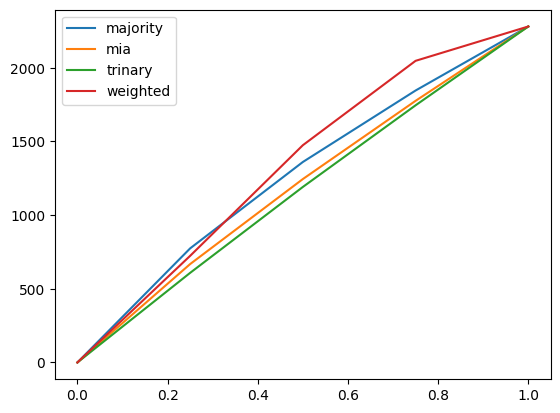

In [13]:
# Missingness of different frequencies
missing_probs = [0,0.25,0.5,0.75,(n-2)/n]

dfs = {0: df.copy()}
n_to_remove = [0]
for i in range(1,len(missing_probs)):
    n_to_remove += [int(missing_probs[i]*n) - sum(n_to_remove[:i])]
    dfs[i] = dfs[i-1].copy()
    for feature in features:
        to_remove = dfs[i].loc[~dfs[i][feature].isna()].sample(n_to_remove[i]).index
        dfs[i].loc[to_remove,feature] = np.nan

# Fit trees
results = pd.DataFrame(columns = [key for key in tree_types], index = missing_probs)
for i,missing_prob in enumerate(missing_probs):
    print(missing_prob)
    X_train = dfs[i].loc[~dfs[i]['test'],features]
    y_train = dfs[i].loc[~dfs[i]['test'],'y']
    X_test  = dfs[i].loc[dfs[i]['test'],features]
    y_test  = dfs[i].loc[dfs[i]['test'],'y']
    for tree_name in tree_types:
        tree = copy.deepcopy(tree_types[tree_name])
        tree.fit(X_train,y_train)

        y_hat = tree.predict(X_test)
        mse = (y_test-y_hat).pow(2).mean()
        results.loc[missing_prob,tree_name] = mse
        print(tree_name)

results.plot()

0
majority
mia
trinary
weighted
0.25
majority
mia
trinary
weighted
0.5
majority
mia
trinary
weighted
0.75
majority
mia
trinary
weighted
0.99998
majority
mia
trinary
weighted


<Axes: >

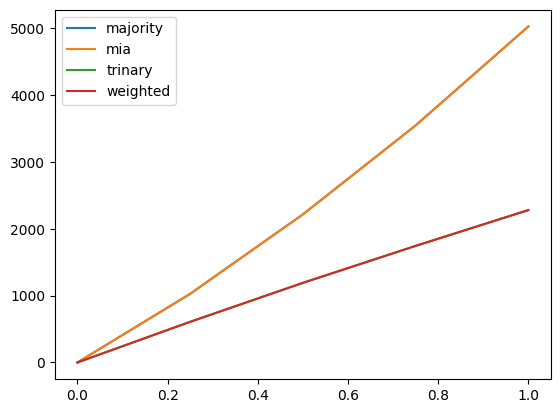

In [15]:
# Missingness of different frequencies ONLY in test data
dfs_2 = {i: dfs[i].copy() for i in range(len(missing_probs))}
for i in range(1,len(missing_probs)):
    dfs_2[i].loc[~dfs_2[i]['test']] = df.loc[~df['test']].copy()

X_train = df.loc[~df['test'],features]
y_train = df.loc[~df['test'],'y']
fitted_trees = {}
for tree_name in tree_types:
    fitted_trees[tree_name] = copy.deepcopy(tree_types[tree_name])
    fitted_trees[tree_name].fit(X_train,y_train)

# Fit trees
results = pd.DataFrame(columns = [key for key in tree_types], index = missing_probs)
for i,missing_prob in enumerate(missing_probs):
    print(missing_prob)
    X_test  = dfs_2[i].loc[dfs_2[i]['test'],features]
    y_test  = dfs_2[i].loc[dfs_2[i]['test'],'y']
    for tree_name in tree_types:
        y_hat = fitted_trees[tree_name].predict(X_test)
        mse = (y_test-y_hat).pow(2).mean()
        results.loc[missing_prob,tree_name] = mse
        print(tree_name)

results.plot()